In [44]:
import gymnasium as gym
import ale_py
# pip install ale-py

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import pickle
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import time
gym.register_envs(ale_py)

In [45]:
class Memory():
    def __init__(self, capacity, file=None):
        if file is not None:
            try:
                with open(file, "rb") as f:
                    d = pickle.load(f)
                    self.memory = d
            except Exception as e:
                self.memory = deque([], maxlen=capacity)
                print(e)
        else:
            self.memory = deque([], maxlen=capacity)

    def push(self, el):
        self.memory.append(el)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def to_list(self):
        return list(self.memory)

In [71]:
class DoubleConv(nn.Module):
    def __init__(self, channels, kernel, pool_kernel):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(channels[0], channels[1], kernel)
        self.conv2 = nn.Conv2d(channels[1], channels[2], kernel)
        self.pool_kernel = pool_kernel

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, self.pool_kernel)
        return x

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.double_conv1 = DoubleConv(channels=(3, 4, 8), kernel=(5,5), pool_kernel=(2,2))
        self.double_conv2 = DoubleConv(channels=(8, 8, 16), kernel=(5,5), pool_kernel=(3,3))



        self.layer1 = nn.Linear(144, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 3)        

    def forward(self, x):
        x = F.max_pool2d(x, (3,3))
        x = self.double_conv1(x)
        x = self.double_conv2(x)
        x = torch.flatten(x, x.dim()-3)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


def optimize_model(optimizer, memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    state_batch = torch.tensor(np.array([state for (state, _, _, _) in transitions]), dtype=torch.float32)
    action_batch = torch.tensor([[action] for (_, action, _, _,) in transitions])
    reward_batch =  torch.tensor([reward for (_, _, reward, _) in transitions])
    next_state_batch = torch.tensor(np.array([s2 for (_, _, _, s2) in transitions]), dtype=torch.float32)


    state_qvalues = policy_net(state_batch)
    state_action_values = state_qvalues.squeeze(1).gather(1, action_batch).squeeze(1)

    with torch.no_grad():
        next_qvalues = target_net(next_state_batch).squeeze(1)
        next_state_values = next_qvalues.max(axis=1).values
        next_state_values = torch.tensor(next_state_values)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()

    loss = criterion(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

In [72]:
def truncate_picture(observation):
    return observation[40:180, 10:-10, :]

def find_pole_middle(observation):
    for i in range(observation.shape[0]):
        where = (observation[i, :, 0] < 100) & (observation[i, :, 1] < 100)
        blue_pixels = sum(where)
        if blue_pixels == 10:
            return sum(np.where(where)[0])/10
    return None

def find_player_pos(observation):
    for i in range(observation.shape[0]):
        where = (observation[i, :, 1] < 100) & (observation[i, :, 2] < 100)
        red_pixels = sum(where)
        if red_pixels > 0:
            return sum(np.where(where)[0])/red_pixels
    return None

In [76]:
def play_game(optimizer, memory, policy_net, target_net, MAX_ITER=1000):
    env = gym.make('ALE/Skiing-v5')
    obs, info = env.reset()
    obs = truncate_picture(obs)
    obs = np.swapaxes(np.swapaxes(obs, 1, 2), 0, 1)
    done = False
    game_start = time.time()
    action_sum, action_cnt = 0, 0
    while not done and action_cnt < MAX_ITER:
        s = time.time()
        optimize_model(optimizer, memory, policy_net, target_net)
        if random.random() < EPSILON:
            res = target_net(torch.tensor(obs, dtype=torch.float32)).detach().numpy()
            action = np.argmax(res)
        else:
            action = int(random.random()*A)
        diff = time.time()-s
        action_sum += (diff)
        print(diff)
        action_cnt += 1
        for _ in range(ACTION_REPETITION):
            observation, reward, done, trunc, info = env.step(action)
            if done:
                break
        observation = truncate_picture(observation)
        observation = np.swapaxes(np.swapaxes(observation, 1, 2), 0, 1)
        memory.push((obs, action, reward, observation))
        obs = observation

    print(f"Game done in {time.time()-game_start}s, avg it length {action_sum/action_cnt}")

    


In [77]:
BATCH_SIZE = 128
GAMMA = 0.95
TAU = 0.005
LR = 0.0005
EPSILON = 0.8
A = 3
MODEL_PATH = "./"
MEMORY_PATH = "./memory"
ACTION_REPETITION = 5


target_net = DQN()
# target_net.load_state_dict(torch.load(MODEL_PATH+"target", weights_only=True, map_location=torch.device('cpu')))
policy_net = DQN()
policy_net.load_state_dict(target_net.state_dict())
# policy_net.load_state_dict(torch.load(MODEL_PATH+"policy", weights_only=True, map_location=torch.device('cpu')))



memory = Memory(10**5, file=MEMORY_PATH)
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

[Errno 2] No such file or directory: './memory'


In [78]:
while True:
    play_game(optimizer, memory, policy_net, target_net)

0.18785548210144043
0.05125236511230469
5.4836273193359375e-06
0.0865011215209961
5.7220458984375e-06
0.054579973220825195
0.12594318389892578
0.1104578971862793
1.049041748046875e-05
0.09466242790222168
0.09447121620178223
0.1254284381866455
0.07882213592529297
0.171980619430542
5.0067901611328125e-06
0.15235400199890137
0.09891724586486816
0.10194659233093262
0.09456253051757812
0.08733439445495605
0.09325814247131348
5.4836273193359375e-06
0.049184560775756836
0.029987812042236328
0.07764768600463867
0.08049416542053223
5.7220458984375e-06
1.6689300537109375e-06
0.11647295951843262
0.07143616676330566
0.08166098594665527
6.67572021484375e-06
0.029316425323486328
0.1248941421508789
0.1531846523284912
0.15022754669189453
0.09072113037109375
0.1294090747833252
0.10949158668518066
0.14783072471618652
6.9141387939453125e-06
0.12464261054992676
0.10724616050720215
0.18843984603881836
0.14593935012817383
0.07376432418823242
0.2135021686553955
3.0994415283203125e-06
0.17352771759033203
0.14

/tmp/ipykernel_60264/3431084814.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state_values = torch.tensor(next_state_values)


1.4178822040557861
1.7779860496520996
2.967149257659912
1.169814109802246
1.3975954055786133
1.210216999053955
1.048335075378418
0.9691135883331299
0.9340231418609619
1.388777494430542
1.349478006362915
1.6445977687835693


KeyboardInterrupt: 

In [79]:
MODEL_PATH = "./"
torch.save(target_net.state_dict(), MODEL_PATH+"target")
torch.save(policy_net.state_dict(), MODEL_PATH+"policy")
with open(MEMORY_PATH, 'wb') as f:
    pickle.dump(memory.memory, f)

In [80]:
model_parameters = filter(lambda p: p.requires_grad, policy_net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

109619


(140, 140, 3)
Pole: 50.0
Player: 64.5
Pole: 50.0
Player: 57.5
Pole: 50.0
Player: 51.5
Pole: 80.0
Player: 52.5
Pole: 80.0
Player: 61.5
Pole: 80.0
Player: 71.5
Pole: 80.0
Player: 82.5
Pole: 88.0
Player: 96.5
Pole: 88.0
Player: 107.5
Pole: 88.0
Player: 117.5


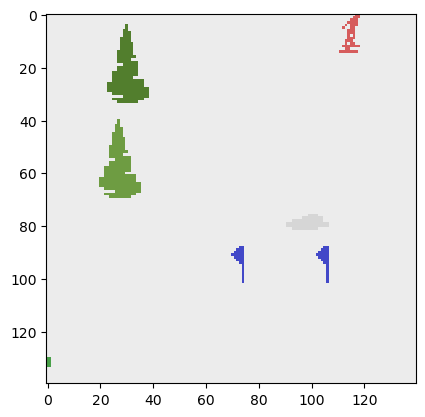

In [ ]:
env = gym.make('ALE/Skiing-v5')
env.reset()
observation, reward, done, trunc, info = env.step(0)
truncated_obs = observation[40:180, 10:-10, :]
print(truncated_obs.shape)

for i in range(10):
    for j in range(10):
        observation, reward, done, trunc, info = env.step(int(random.random()*3))
    truncated_obs = truncate_picture(observation)
    print(f"Pole: {find_pole_middle(truncated_obs)}")
    print(f"Player: {find_player_pos(truncated_obs)}")
plt.imshow(truncated_obs, interpolation='nearest')
plt.show()